# Demo de implementación de un algoritmo de Bandadas de Pájaros (Particle Swarm Optimization o PSO) para resolver un SUDOKU intentando reducir la cantidad de errores
El código es una adaptación del ejemplo de la librería DEAP disponible en https://deap.readthedocs.io/en/master/ pero no utiliza la librería (no son necesarios los operadores ni clases) y se mejora

In [1]:
#@title Cargar librerías
import random
import math
import numpy as np
import matplotlib.pyplot as plt

import operator
import copy

import matplotlib
import matplotlib.pyplot as plt
import networkx
from IPython.display import display
from PIL import Image

import matplotlib as mpl
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import ipywidgets as widgets
from ipywidgets import Box, Layout, IntSlider
from ipywidgets import Layout
from IPython.display import clear_output

print("\nLibrerías importadas")


Librerías importadas


In [2]:
#@title PARÁMETROS

#@markdown Parámetros del Algoritmo PSO:

# Cantidad de Ciclos de la Corrida
CANT_CICLOS = 10000 #@param {type:"integer"}

# Cantidad de Particulas
CANT_PARTICULAS = 50 #@param {type:"slider", min:1, max:100, step:1}

# Parámetros de atracción
COEF_ATRACCION_MEJOR_CICLO = 3 #@param {type:"number"}
COEF_ATRACCION_MEJOR_CORRIDA = 2 #@param {type:"number"}

print("\nParámetros de la Corrida definidos")


Parámetros de la Corrida definidos


In [3]:
#@title clase SUDOKU

# @markdown Tamaño del Tablero:
Tamaño_Sudoku_NxN = '9x9'  #@param [ '4x4', '9x9', '16x16', '25x25' ]
# @markdown Indica cómo se asignan valores predefinidos del Tablero (Manual o Azar):
Manual_Valores_Predefinidos_Lista = '  4  7 3            5   7        2   6  73      8     8     3   4 3   7 1    89 6' #@param {type:"string"}
Azar_Cantidad_Valores_Predefinidos = 5 # @param {type:"slider", min:0, max:25, step:1}

# posibles valores a usar en el sudoku
SUDOKU_VALORES_POSIBLES = [' ', '1','2','3','4','5','6','7','8','9', '0', 'A','B','C','D','E','F','G','H','I','J','K','L','M','N','Ñ','O','P','Q','R','S','T','U','V','W','X','Y','Z', '!','?','#','$','%','&','/','+','*','-']

# clase Sudoku
class Sudoku(object):

    def __init__(self, Tamaño_NxN='9x9'):
      # determina tamaño del tablero (siempre es cuadrado)
      try:
        self._N = int(Tamaño_NxN.lower().split("x")[0])
      except:
        print("No se puede definir tamaño del tablero, se usa valor por defecto 9x9!")
      # determina tamaño filas / columnas (N - 1)
      self._tamFilaCol = self._N-1
      # obtiene el tamaño de las regiones (raiz cuadrada de N)
      self._tamRegion = int(self._N**0.5)
      if (self._tamRegion**2) !=  self._N:
        # controla que el tamaño es un cuadrado perfecto
        raise Exception("El tamaño del tablero no es válido: " + str(self._N) + "x" + str(self._N) + "!")
      # determina valores a usar
      if len(SUDOKU_VALORES_POSIBLES) < (self._N+1):
        # controla que haya definidos valores para tamaño tablero
        raise Exception("No existen suficientes valores (" + str(len(SUDOKU_VALORES_POSIBLES)) + ") para el tamaño del tablero: " + str(self._N) + "x" + str(self._N) + "!")
      self._ValoresUsar = SUDOKU_VALORES_POSIBLES[0: self._N+1]
      # inicializa los vectores que representan el tablero
      self.Tablero = np.zeros((self._tamFilaCol+1, self._tamFilaCol+1))

    # Función para definir los valores predefinidos del tablero al azar
    def asignarValoresAlAzar(self, cantidad=1):
      for _ in range(cantidad):
          NoAgrego = True
          cantIt = 0
          while (NoAgrego and (cantIt<100)):
            cantIt += 1
            # define posición al azar
            auxPosX = random.randint(0, self._tamFilaCol)
            auxPosY = random.randint(0, self._tamFilaCol)
            # controla que el valor no este asignado
            if self.Tablero[auxPosX][auxPosY]==0:
              # determina valor a asignar
              auxVal = random.randint(1, len(self._ValoresUsar)-1)
              # prueba agregarlo
              self.Tablero[auxPosX][auxPosY] = auxVal
              # controla que no genere error
              cantErr = self.cuentaErrores()
              if cantErr[0]==0:
                # está bien, lo deja
                NoAgrego = False
              else:
                # genera error, resetea tablero
                self.Tablero[auxPosX][auxPosY] = 0

    # Función para asignar manualmente un valor
    def asignarValorManual(self, posX, posY, valor, showMessage=False):
        # chequea posiciones
        posX = posX - 1
        if posX < 0:
          posX = 0
        elif posX > self._tamFilaCol:
          posX = self._tamFilaCol
        posY = posY - 1
        if posY < 0:
          posY = 0
        elif posY > self._tamFilaCol:
          posY = self._tamFilaCol
        # controla que el valor no este asignado
        if self.Tablero[posX][posY]>0:
          if showMessage:
            print("La posición [" + str(posX+1) + "," + str(posY+1) + "] ya está asignada: " + self._formatearValorPos(posX,posY) + "-> se ignora asignación!")
          return False
        # controla valor
        valor = str(valor)
        if valor not in self._ValoresUsar:
          if showMessage:
            print("Valor a asignar no válido: " + str(valor) + "-> se ignora asignación!")
          return False
        valorId = self._ValoresUsar.index(valor)
        # asigna
        self.Tablero[posX, posY] = valorId
        return True

    # Función para asigna valores a partir de una lista (individuo)
    def asignarValoresLista(self, valoresList, showMessage=False, esValorPos=False):
      # controla largo de lissta
      if len(valoresList) > self.devuelveTamanioTableroComoLista():
        if showMessage:
          print("Se indican más valores que los posibles a asignar, se ignora toda la lista!")
        return len(valoresList)
      # devuelve la cantidad de valores ignorados (por ya estar asignados)
      cantIgnorados = 0
      cantColumnas = self._tamFilaCol+1
      for posLista in range(len(valoresList)):
        # determina la posición
        posX = (posLista//cantColumnas)+1
        posY = (posLista%cantColumnas)+1
        valor = valoresList[posLista]
        if esValorPos:
            # el valor es el Id de Valores a usar
            valor = self._ValoresUsar[valor]
        else:
            # el valor es el Valor a usar
            valor = str(valor)
        # intenta asignarlo
        res = self.asignarValorManual(posX, posY, valor, showMessage=showMessage)
        if not(res):
          cantIgnorados += 1
      return cantIgnorados

    # Función para devolver el  tamaño debería tener el tablero como lista
    def devuelveTamanioTableroComoLista(self):
      return self._N**2

    # Función que devuelve el mínimo valor que se puede asignar en el tablero
    def devuelveMinimoValorAsignarEnTablero(self):
      return 1

    # Función que devuelve el máximo valor que se puede asignar en el tablero
    def devuelveMaximoValorAsignarEnTablero(self):
      return len(self._ValoresUsar)-1

    # Función auxiliar para contar duplicados por fila
    def _cuentaDuplicadosFila(self, matriz):
      cantDupl = 0
      for i in range(0, len(matriz)):
        uniqList, freqList = (np.unique(matriz[i], return_counts=True))
        for v, f in zip(uniqList, freqList):
          if (v>0) and (f>1):
            cantDupl += f-1
      return cantDupl

    # Función auxiliar para contar duplicados por region
    def _cuentaDuplicadosRegiones(self):
      cantDupl = 0
      rangoRegiones = range(len(self.Tablero)//self._tamRegion)
      for rX in rangoRegiones:
        # genera la región X
        iniRegionX = rX*self._tamRegion
        finRegionX = iniRegionX+self._tamRegion
        for rY in rangoRegiones:
          # genera la región Y
          auxRegion = []
          iniRegionY = rY*self._tamRegion
          finRegionY = iniRegionY+self._tamRegion
          for cols in self.Tablero[iniRegionX : finRegionX]:
            # genera la región
            auxRegion.append( cols[iniRegionY : finRegionY] )
          auxRegion = np.array(auxRegion)
          # cuenta duplicados en la region
          uniqList, freqList = (np.unique(auxRegion, return_counts=True))
          for v, f in zip(uniqList, freqList):
            if (v>0) and (f>1):
              cantDupl += f-1
      return cantDupl

    # Función para contar la cantidad de errores totales del sudo,u
    def cuentaErrores(self):
      # cuenta errores por filas
      errFilas = self._cuentaDuplicadosFila(self.Tablero)
      # cuenta errores por columnas (transpone el tablero)
      errColumnas = self._cuentaDuplicadosFila( np.transpose(self.Tablero) )
      # cuenta errores por sectores
      errRegiones = self._cuentaDuplicadosRegiones()
      # total errores
      errTotal = (errFilas+errColumnas+errRegiones)
      # sin definir
      cantZero = (self.Tablero == 0).sum()
      return errTotal, errFilas, errColumnas, errRegiones, cantZero

    # Función auxiliar para formatear valor a mostrar del tablero
    def _formatearValorPos(self, posX, posY):
      return self._ValoresUsar[ int(self.Tablero[posX][posY]) ]

    # Función que muestra la información sobre el Mapa de Búsqueda
    def printInformacion(self, mostrarErrores=True):
      print("\n** SUDOKU: " )
      ##print(self.Tablero)
      # formatea para demarcar las regiones
      print("\t", end="")
      print("--" * (self._tamFilaCol+1), end="-\n")
      for i in range(len(self.Tablero)):
        print("\t", end="|")
        for j in range(len(self.Tablero[i])):
          if j==0:
            carSep = " "
          elif ((j+1)%self._tamRegion)==0:
            carSep = "|"
          elif j==len(self.Tablero[i]):
            carSep = "|"
          else:
            carSep = " "
          print( self._formatearValorPos(i, j) , end=carSep)
        print("")
        if (((i+1)%self._tamRegion)==0) or (i==len(self.Tablero)):
          print("\t", end="")
          print("--" * (self._tamFilaCol+1), end="-\n")
      if mostrarErrores:
        # si corresponde muestra la cantidad de errores
        cantErrores = self.cuentaErrores()
        if cantErrores[4]>0:
          print("\n** Casilleros sin definir: ", cantErrores[4])
        if cantErrores[0]>0:
          print("\n** Cantidad de Errores: ", cantErrores[0])
          print("\t\t en Filas: ", cantErrores[1])
          print("\t\t en Columnas: ", cantErrores[2])
          print("\t\t en Regiones: ", cantErrores[3])
      print("\n")

print("\nClase SUDOKU definida")

# parámetros para función heruristica
PESO_IGNORADOS = 0
PESO_ERRORES_FILA = 1
PESO_ERRORES_COLUMNA = 1
PESO_ERRORES_REGION = 2
PESO_SIN_DEFINIR = 5

# clase wrapper Mapa para usar Sudoku con Abeja
class MapaSudoku(object):

  def __init__(self, sudokuOriginal, valMaximoGlobal=1000):
    self.sudokuOriginal = sudokuOriginal
    if valMaximoGlobal<0:
      self.valMaximoGlobal = sudokuOriginal.devuelveTamanioTableroComoLista()*(PESO_SIN_DEFINIR+PESO_ERRORES_REGION+PESO_ERRORES_COLUMNA+PESO_ERRORES_FILA+PESO_IGNORADOS)
    else:
      self.valMaximoGlobal = valMaximoGlobal

  @property
  def limMin(self):
    return self.sudokuOriginal.devuelveMinimoValorAsignarEnTablero()

  @property
  def limMax(self):
    return self.sudokuOriginal.devuelveMaximoValorAsignarEnTablero()

  @property
  def cantPosiciones(self):
    return self.sudokuOriginal.devuelveTamanioTableroComoLista()

  # genera nuevo soduku en base a la posiones
  def generarSudokuListaPos(self, listaPos):
    # hace una copia del sudoku original
    s = copy.deepcopy(self.sudokuOriginal)
    # prueba asignar los valores del individuo (lista valores)
    cantIgnorados = s.asignarValoresLista(list(listaPos), esValorPos=True)
    # calcula la cantidad de errores
    cantErrores = s.cuentaErrores()
    return s, cantIgnorados, cantErrores

  # definimos la función de aptitud a evaluar
  # se convierte el problema a maximizar para no afectar al algoritmo)
  def funcHeuristica(self, listaPos):
      # genera el sudoku
      _, cantIgnorados, cantErrores = self.generarSudokuListaPos(listaPos)
      # devuelve heurística
      h = self.valMaximoGlobal - (cantIgnorados*PESO_IGNORADOS
            + cantErrores[1]*PESO_ERRORES_FILA
            + cantErrores[2]*PESO_ERRORES_COLUMNA
            + cantErrores[3]*PESO_ERRORES_REGION
            + cantErrores[4]*PESO_SIN_DEFINIR)
      return h

  # muestra información
  def printInformacion(self, listaPos=None):
    if listaPos is None:
      s = self.sudokuOriginal
    else:
      s, _, _ = self.generarSudokuListaPos(listaPos)
    s.printInformacion(True)

print("\nClase MAPA-SUDOKU definida")

print("\n> Creando nuevo SUDOKU.")
sudokuOriginal = Sudoku(Tamaño_Sudoku_NxN)

# si tiene la lista mnual definida, la carga sino crea nueva clase
if Manual_Valores_Predefinidos_Lista != "":
  print("\n> Usando lista de valores predefinidos manual.")
  if "," in Manual_Valores_Predefinidos_Lista:
    listaAux = list(Manual_Valores_Predefinidos_Lista.split(","))
  else:
    listaAux = list(Manual_Valores_Predefinidos_Lista)
  sudokuOriginal.asignarValoresLista(listaAux, esValorPos=False, showMessage=True)
else:
  # asigna valores iniciales al azar
  if Azar_Cantidad_Valores_Predefinidos > 0:
    print("\n> Usando valores predefinidos al azar.")
    sudokuOriginal.asignarValoresAlAzar(Azar_Cantidad_Valores_Predefinidos)

# lo muestra
sudokuOriginal.printInformacion()

# inicializa mapa auxiliar
mapa = MapaSudoku(sudokuOriginal)



Clase SUDOKU definida

Clase MAPA-SUDOKU definida

> Creando nuevo SUDOKU.

> Usando lista de valores predefinidos manual.

** SUDOKU: 
	-------------------
	|    4|    7|  3  |
	|     |     |     |
	|    5|     |7    |
	-------------------
	|     |     |2    |
	|  6  |  7 3|     |
	|     |8    |     |
	-------------------
	|8    |     |3    |
	|  4  |3    |  7  |
	|1    |    8|9   6|
	-------------------

** Casilleros sin definir:  62




In [4]:
#@title clase PARTICULA

class Particula(object):

    def __init__(self, mapa):
        self.mapa = mapa
        self.pos = [random.randint(self.mapa.limMin, self.mapa.limMax) for _ in range(mapa.cantPosiciones)]
        self.valor = self.mapa.funcHeuristica(self.pos)
        self.velocidad = [random.uniform(self.mapa.limMin//10, self.mapa.limMax//10) for _ in range(len(self.pos))]


    def _reset(self):
        self.pos = []
        self.valor = -9999
        self.velocidad = []

    @property
    def heuristica(self):
        return round(self.valor, 2)

    @property
    def posicion(self):
        return self.pos

    def moverse(self, mejorCiclo, mejorCorrida, coefAtraccMejorCiclo=1.5, coefAtraccMejorCorrida=3):

        for i in range(len(self.pos)):
              # calcula el desplazamiento (velocidad) en base a la atracción a la mejor del ciclo y global
            ajusteVel = (coefAtraccMejorCiclo * random.uniform(0, 1) * (mejorCiclo.posicion[i]-self.pos[i])) \
                        + (coefAtraccMejorCorrida * random.uniform(0, 1) * (mejorCorrida.posicion[i]-self.pos[i]))
            self.velocidad[i] = self.velocidad[i] + ajusteVel

              # ajusta la posición de la partícula (se ajusta la velocidad para que cambie de a poco)
            self.pos[i] = int(self.pos[i] + self.velocidad[i])

              # revisa no haber superado los límites del mapa
            if self.pos[i] < self.mapa.limMin:
                  self.pos[i] = self.mapa.limMin
            elif self.pos[i] > self.mapa.limMax:
                  self.pos[i] = self.mapa.limMax

          # actualiza su heurística
        self.valor = self.mapa.funcHeuristica(self.pos)
        return copy.deepcopy( self.pos )

print("\nClase Particula definida")


Clase Particula definida


In [5]:
#@title EJECUCIÓN DE LA CORRIDA

# Indica si se muestra el detalle de cada ciclo
MUESTRA_DETALLE = True #@param {type:"boolean"}

# Muestra su información
sudokuOriginal.printInformacion()

# Determina mínima Heuristica para finalizar el algoritmo
MIN_HEURISTICA_FINALIZAR = mapa.valMaximoGlobal - 1
print("-- Mínima heurística para finalizar la Corrida: ", MIN_HEURISTICA_FINALIZAR, "--")


# Define una función auxiliar para calcular estadísticas
def CalculoEstadisticas(ciclo, indivPobla, mejorPartCiclo=None, mejorPartCorrida=None):
    # calcula
    arrApt = np.array([i.heuristica for i in indivPobla])
    auxProm = np.sum(arrApt) / len(indivPobla)
    auxMax = np.max(arrApt)
    auxMin = np.min(arrApt)
    # muestra
    print("\n-- Ciclo  %i --" % ciclo)
    if mejorPartCiclo is not None:
        print("      Mejor Partícula Ciclo:", mejorPartCiclo.posicion, "\n\t\t\t { ", mejorPartCiclo.heuristica, " } ")
    if mejorPartCorrida is not None:
        print("      Mejor Partícula Corrida:", mejorPartCorrida.posicion, "\n\t\t\t { ", mejorPartCorrida.heuristica, " }")
    print("      Max: ", round(auxMax, 3), " / Promedio: ", round(auxProm, 3), " / Min: ", round(auxMin, 3))
    return auxMax, auxProm, auxMin

# vectores auxiliares
ciclo = 1
mejorPartCiclo = None
mejorPartCorrida = None
mejorPartCorrida_ciclo = 0
ciclosParticulas = []
ciclosMaxHeuristica = []
ciclosPromHeuristica = []
ciclosMinHeuristica = []
partPobla = []

# Define la población de las Particulas
ciclosParticulas.append( [] )
for i in range(CANT_PARTICULAS):
  p = Particula(mapa)
  partPobla.append( p )
  ciclosParticulas[0].append( copy.deepcopy( p.posicion ) )

# Cálcula estadísticas y muestra
if MUESTRA_DETALLE:
  auxMax, auxProm, auxMin = CalculoEstadisticas(0, partPobla, mejorPartCiclo, mejorPartCorrida)
  ciclosMaxHeuristica.append( auxMax )
  ciclosPromHeuristica.append( auxProm )
  ciclosMinHeuristica.append( auxMin )

# Finaliza cuando llegue a la cantidad de ciclos
#     o cuando la heurística del mejor sea mayor a un mínimo
while (ciclo < CANT_CICLOS) \
        and ((mejorPartCiclo==None) or mejorPartCorrida.heuristica<MIN_HEURISTICA_FINALIZAR):

    # Evalúa las particulas de la población para determinar las mejores
    rankingParticulas = sorted(partPobla, key=operator.attrgetter('heuristica'), reverse=True)
    mejorPartCiclo = rankingParticulas[0]
    if mejorPartCorrida == None or mejorPartCiclo.heuristica > mejorPartCorrida.heuristica:
        # congela la particula con la mejor posición encontrada en la corrida
        mejorPartCorrida = copy.deepcopy( mejorPartCiclo )
        mejorPartCorrida_ciclo = ciclo
    ##ciclosMaxAptitud.append( rankingParticulas[0].heuristica )

    # Cálcula estadísticas y muestra
    if MUESTRA_DETALLE:
      auxMax, auxProm, auxMin = CalculoEstadisticas(ciclo, partPobla, mejorPartCiclo, mejorPartCorrida)
      ciclosMaxHeuristica.append( auxMax )
      ciclosPromHeuristica.append( auxProm )
      ciclosMinHeuristica.append( auxMin )


    # Actualiza la posición de las partículas
    ciclosParticulas.append( [] )
    for p in partPobla:
        nuevaPos = p.moverse( mejorPartCiclo, mejorPartCorrida, COEF_ATRACCION_MEJOR_CICLO, COEF_ATRACCION_MEJOR_CORRIDA )
        ciclosParticulas[ciclo].append( nuevaPos )

    ciclo = ciclo + 1

print("\n-- Corrida Finalizada en %i ciclos --\n" % ciclo )
print("== Mejor Partícula de la Corrida:", mejorPartCorrida.posicion, "\n\t\t\t { ", mejorPartCorrida.heuristica, " } ==")
mapa.printInformacion(mejorPartCorrida.posicion)

Se han truncado las últimas 5000 líneas del flujo de salida.
      Mejor Partícula Corrida: [1, 8, 8, 1, 5, 7, 7, 9, 4, 5, 7, 9, 3, 9, 2, 8, 1, 2, 9, 8, 8, 9, 1, 3, 1, 7, 6, 6, 3, 8, 9, 4, 9, 2, 2, 4, 1, 4, 6, 5, 9, 1, 6, 7, 9, 9, 5, 4, 8, 6, 3, 2, 5, 2, 9, 3, 7, 6, 2, 4, 1, 5, 5, 4, 6, 6, 9, 9, 1, 4, 8, 7, 7, 2, 5, 2, 1, 2, 4, 3, 4] 
			 {  913  }
      Max:  874  / Promedio:  852.02  / Min:  837

-- Ciclo  9290 --
      Mejor Partícula Ciclo: [1, 9, 9, 1, 9, 5, 6, 9, 5, 3, 9, 9, 3, 9, 2, 7, 1, 1, 9, 9, 9, 9, 1, 1, 1, 5, 3, 9, 1, 1, 9, 6, 9, 1, 1, 3, 1, 9, 9, 1, 9, 1, 2, 5, 9, 9, 1, 5, 5, 4, 3, 1, 1, 1, 9, 1, 6, 9, 1, 1, 1, 1, 8, 1, 9, 6, 9, 9, 1, 1, 9, 9, 4, 1, 4, 3, 1, 2, 8, 5, 4] 
			 {  865  } 
      Mejor Partícula Corrida: [1, 8, 8, 1, 5, 7, 7, 9, 4, 5, 7, 9, 3, 9, 2, 8, 1, 2, 9, 8, 8, 9, 1, 3, 1, 7, 6, 6, 3, 8, 9, 4, 9, 2, 2, 4, 1, 4, 6, 5, 9, 1, 6, 7, 9, 9, 5, 4, 8, 6, 3, 2, 5, 2, 9, 3, 7, 6, 2, 4, 1, 5, 5, 4, 6, 6, 9, 9, 1, 4, 8, 7, 7, 2, 5, 2, 1, 2, 4, 3, 4] 
			 {  913  }
 

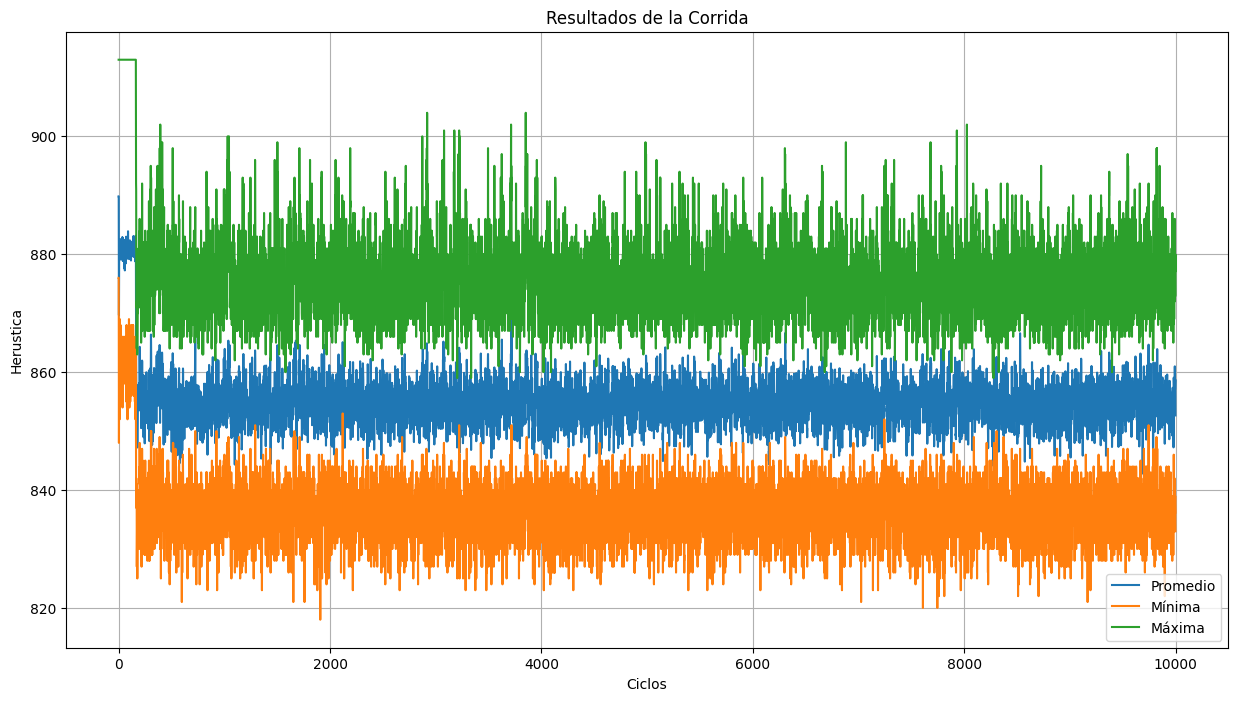

In [6]:
#@title  MOSTRAR GRAFICO DE LA CORRIDA
plt.figure(figsize=(15,8))
plt.plot(ciclosPromHeuristica)
plt.plot(ciclosMinHeuristica)
plt.plot(ciclosMaxHeuristica)
plt.title('Resultados de la Corrida')
plt.xlabel('Ciclos')
plt.ylabel('Herustica')
plt.legend(['Promedio', 'Mínima', 'Máxima'], loc='lower right')
plt.grid(True)
plt.show()
